In [1]:
import warnings 
warnings.filterwarnings('ignore') # feel free to comment this out if you want to see warnings 

import csv 
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator

from keras.models import Sequential
from keras.layers import Dense, LSTM, Input, Flatten


from statsmodels.tools.eval_measures import rmse

import numpy as np
from tabulate import tabulate

Using TensorFlow backend.


In [2]:
covid = pd.read_csv('../data/corona-virus-report/covid_19_clean_complete.csv')

We want to see what our data looks like:

In [3]:
covid.head(15)

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Thailand,15.0000,101.0000,1/22/20,2.0,0.0,0.0
1,NaN,Japan,36.0000,138.0000,1/22/20,2.0,0.0,0.0
2,NaN,Singapore,1.2833,103.8333,1/22/20,0.0,0.0,0.0
3,NaN,Nepal,28.1667,84.2500,1/22/20,0.0,0.0,0.0
4,NaN,Malaysia,2.5000,112.5000,1/22/20,0.0,0.0,0.0
5,British Columbia,Canada,49.2827,-123.1207,1/22/20,0.0,0.0,0.0
6,New South Wales,Australia,-33.8688,151.2093,1/22/20,0.0,0.0,0.0
7,Victoria,Australia,-37.8136,144.9631,1/22/20,0.0,0.0,0.0
8,Queensland,Australia,-28.0167,153.4000,1/22/20,0.0,0.0,0.0
9,NaN,Cambodia,11.5500,104.9167,1/22/20,0.0,0.0,0.0


### Pre-processing

We want to isolate our data to find: Country, Date, and Confirmed Cases 

In [4]:
covid = covid[['Country/Region', 'Date', 'Confirmed']]

Let's see how the US is doing 

In [5]:
US = covid.loc[covid['Country/Region'] == "US"]
US

,Country/Region,Date,Confirmed
98,US,1/22/20,0.0
99,US,1/22/20,0.0
100,US,1/22/20,0.0
101,US,1/22/20,0.0
102,US,1/22/20,0.0
...,...,...,...
19136,US,3/23/20,23.0
19150,US,3/23/20,27.0
19167,US,3/23/20,NaN
19210,US,3/23/20,6.0


We notice that by isolating rows with Country/Region == US, we will end up with multiple rows with the same date. This is because this dataset is reporting different states as well. What we want to do is sum up all "Confirmed" values based on grouped dates. 

Also we need to convert the Date column from str to datetime in order to sort 

In [6]:
US[['Date']] = US['Date'].apply(pd.to_datetime)

In [7]:
col = ["Country/Region","Date"]
US = US.groupby(col, as_index=False).Confirmed.sum()

In [8]:
US = US.sort_values(['Date'], ascending=[True])

In [9]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(US)

   Country/Region       Date  Confirmed
0              US 2020-01-22        0.0
1              US 2020-01-23        0.0
2              US 2020-01-24        0.0
3              US 2020-01-25        0.0
4              US 2020-01-26        0.0
5              US 2020-01-27        0.0
6              US 2020-01-28        0.0
7              US 2020-01-29        0.0
8              US 2020-01-30        0.0
9              US 2020-01-31        0.0
10             US 2020-02-01        0.0
11             US 2020-02-02        0.0
12             US 2020-02-03        0.0
13             US 2020-02-04        0.0
14             US 2020-02-05        0.0
15             US 2020-02-06        0.0
16             US 2020-02-07        0.0
17             US 2020-02-08        0.0
18             US 2020-02-09        0.0
19             US 2020-02-10        0.0
20             US 2020-02-11        0.0
21             US 2020-02-12        0.0
22             US 2020-02-13        0.0
23             US 2020-02-14        0.0


Since not all countries will "line" up with each other in terms of dates, let's set a mark where we only start looking after the 10th or so confirmed case 

In [10]:
US = US.loc[US["Confirmed"] > 10.0] 
US

,Country/Region,Date,Confirmed
33,US,2020-02-24,36.0
34,US,2020-02-25,36.0
35,US,2020-02-26,42.0
36,US,2020-02-27,42.0
37,US,2020-02-28,44.0
38,US,2020-02-29,44.0
39,US,2020-03-01,44.0
40,US,2020-03-02,45.0
41,US,2020-03-03,45.0
42,US,2020-03-04,45.0


Now we should reset the index, so that it now counts the days after the first 10th confirmed case. This will help lining up all countries together 

In [11]:
US = US.reset_index(drop=True)
US

,Country/Region,Date,Confirmed
0,US,2020-02-24,36.0
1,US,2020-02-25,36.0
2,US,2020-02-26,42.0
3,US,2020-02-27,42.0
4,US,2020-02-28,44.0
5,US,2020-02-29,44.0
6,US,2020-03-01,44.0
7,US,2020-03-02,45.0
8,US,2020-03-03,45.0
9,US,2020-03-04,45.0


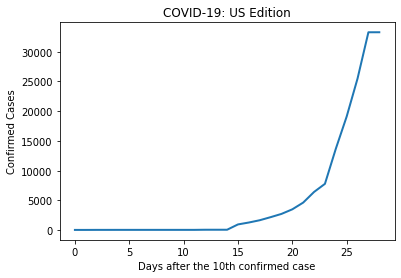

In [12]:
plt.plot(US.index, US['Confirmed'], linewidth = 2)
plt.title("COVID-19: US Edition")
plt.xlabel("Days after the 10th confirmed case")
plt.ylabel("Confirmed Cases")
plt.show()

We should focus on 3 main countries for now 

In [13]:
all_countries = list(covid["Country/Region"].unique())

In [14]:
china = covid.loc[covid['Country/Region'] == "China"]
china[['Date']] = china['Date'].apply(pd.to_datetime)
china = china.sort_values(['Date'], ascending=[True])
col = ["Country/Region","Date"]
china = china.groupby(col, as_index=False).Confirmed.sum()
china = china.loc[china["Confirmed"] > 10.0] 
china = china.reset_index(drop=True)


italy = covid.loc[covid['Country/Region'] == "Italy"]
italy[['Date']] = italy['Date'].apply(pd.to_datetime)
italy = italy.sort_values(['Date'], ascending=[True])
col = ["Country/Region","Date"]
italy = italy.groupby(col, as_index=False).Confirmed.sum()
italy = italy.loc[italy["Confirmed"] > 10.0] 
italy = italy.reset_index(drop=True)

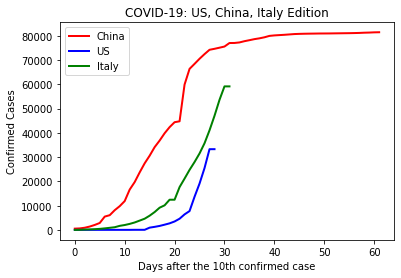

In [15]:
plt.plot(china.index, china['Confirmed'], 'r', linewidth = 2, label="China")
plt.plot(US.index, US['Confirmed'],'b',linewidth = 2, label="US")
plt.plot(italy.index, italy['Confirmed'],'g',linewidth = 2, label="Italy")
plt.title("COVID-19: US, China, Italy Edition")
plt.xlabel("Days after the 10th confirmed case")
plt.ylabel("Confirmed Cases")
plt.legend()
plt.show()

Moving forward, you can call "US", "Italy", or "China" to work for either country

---

# Predict China

In [16]:
china = china[["Date", "Confirmed"]]

In [17]:
china.Date = pd.to_datetime(china.Date)

In [18]:
china = china.set_index("Date")

In [19]:
train_data = china[:len(china)-3]
test_data = china[len(china)-3:]

In [20]:
scaler = MinMaxScaler()
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [21]:
n_input = 3
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [22]:
lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

Instructions for updating:
Colocations handled automatically by placer.


In [23]:
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [24]:
lstm_model.fit_generator(generator,epochs=20)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
56/56 [==============================] - 0s 9ms/step - loss: 0.2259
Epoch 2/20
56/56 [==============================] - 0s 4ms/step - loss: 0.0084
Epoch 3/20
56/56 [==============================] - 0s 5ms/step - loss: 0.0027
Epoch 4/20
56/56 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 5/20
56/56 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 6/20
56/56 [==============================] - 0s 7ms/step - loss: 0.0014
Epoch 7/20
56/56 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 8/20
56/56 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 9/20
56/56 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 10/20
56/56 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 11/20
56/56 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 12/20
56/56 [==============================] - 0s 6ms/step - loss: 0.0010
E

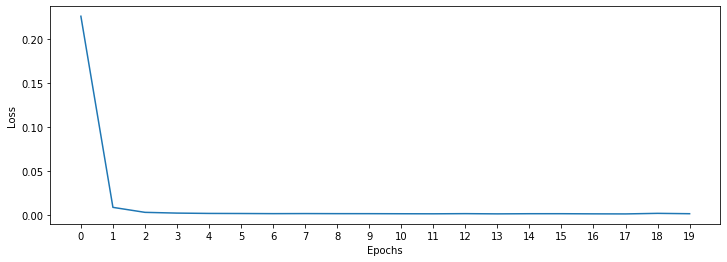

In [25]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [26]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [27]:
lstm_predictions_scaled

[array([0.97436225], dtype=float32),
 array([0.9704759], dtype=float32),
 array([0.9642021], dtype=float32)]

In [28]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
lstm_predictions

array([[79180.98263383],
       [78867.34705782],
       [78361.03835833]])

In [29]:
test_data['LSTM_Predictions'] = lstm_predictions
test_data

,Confirmed,LSTM_Predictions
Date,,
2020-03-21,81305.0,79180.982634
2020-03-22,81397.0,78867.347058
2020-03-23,81439.0,78361.038358


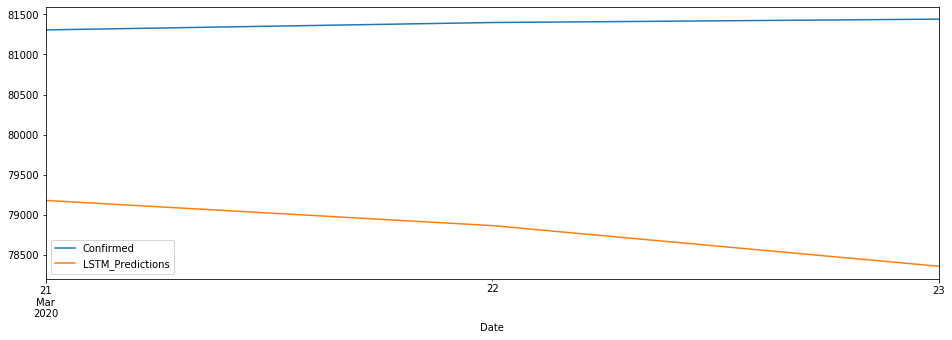

In [30]:
test_data['Confirmed'].plot(figsize = (16,5), legend=True)
test_data['LSTM_Predictions'].plot(legend = True);

In [31]:
lstm_rmse_error_china = rmse(test_data['Confirmed'], test_data["LSTM_Predictions"])
lstm_mse_error_china = lstm_rmse_error_china**2
mean_value = china['Confirmed'].mean()

print(f'MSE Error: {lstm_mse_error_china}\nRMSE Error: {lstm_rmse_error_china}\nMean: {mean_value}')

MSE Error: 6794813.882422013
RMSE Error: 2606.6863797591786
Mean: 56954.33870967742


# Predict US

In [32]:
US = US[["Date", "Confirmed"]]
US.Date = pd.to_datetime(US.Date)
US = US.set_index("Date")
train_data = US[:len(US)-3]
test_data = US[len(US)-3:]

In [33]:
scaler = MinMaxScaler()
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [34]:
n_input = 3
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [35]:
lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

In [36]:
lstm_model.fit_generator(generator,epochs=20, verbose=0)

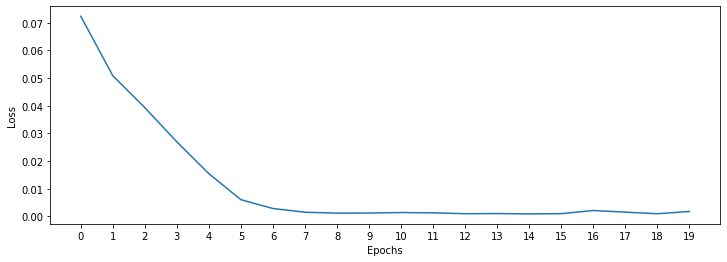

In [37]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [38]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

    
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
print(lstm_predictions)
test_data['LSTM_Predictions'] = lstm_predictions
print(test_data)

[[26370.77985954]
 [40756.77970505]
 [63665.87434387]]
            Confirmed  LSTM_Predictions
Date                                   
2020-03-21    25489.0      26370.779860
2020-03-22    33272.0      40756.779705
2020-03-23    33276.0      63665.874344


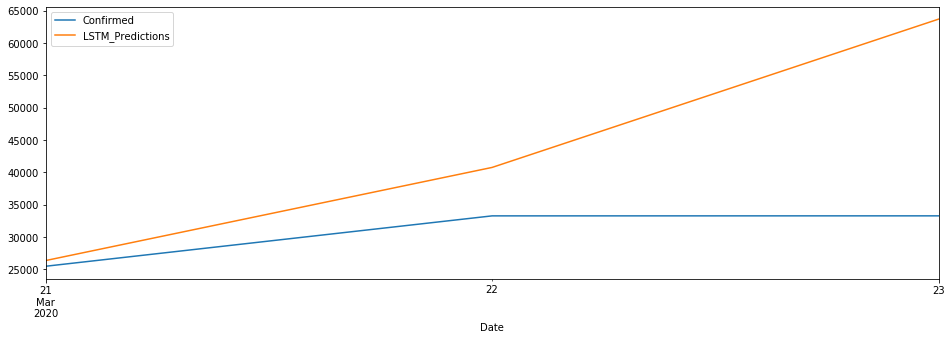

In [39]:
test_data['Confirmed'].plot(figsize = (16,5), legend=True)
test_data['LSTM_Predictions'].plot(legend = True);

In [40]:
lstm_rmse_error_us = rmse(test_data['Confirmed'], test_data["LSTM_Predictions"])
lstm_mse_error_us = lstm_rmse_error_us**2
mean_value = US['Confirmed'].mean()

print(f'MSE Error: {lstm_mse_error_us}\nRMSE Error: {lstm_rmse_error_us}\nMean: {mean_value}')

MSE Error: 326781308.53004056
RMSE Error: 18077.093475723374
Mean: 5402.379310344828


---

## Italy

In [41]:
italy = italy[["Date", "Confirmed"]]
italy.Date = pd.to_datetime(italy.Date)
italy= italy.set_index("Date")

train_data = italy[:len(italy)-3]
test_data = italy[len(italy)-3:]

In [42]:
scaler = MinMaxScaler()
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [43]:
n_input = 3
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [44]:
lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

In [45]:
lstm_model.fit_generator(generator,epochs=20, verbose=0)

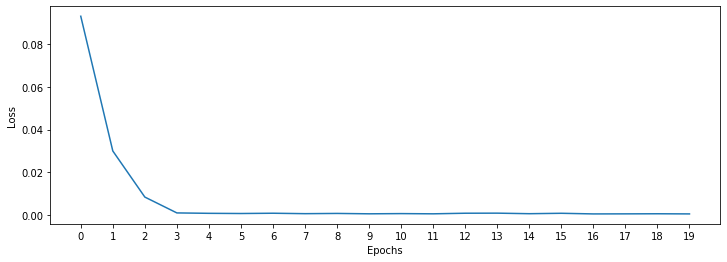

In [46]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [47]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

    
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
print(lstm_predictions)
test_data['LSTM_Predictions'] = lstm_predictions
print(test_data)
test_data

[[53363.3274709 ]
 [61175.42231202]
 [70441.01353967]]
            Confirmed  LSTM_Predictions
Date                                   
2020-03-21    53578.0      53363.327471
2020-03-22    59138.0      61175.422312
2020-03-23    59138.0      70441.013540


,Confirmed,LSTM_Predictions
Date,,
2020-03-21,53578.0,53363.327471
2020-03-22,59138.0,61175.422312
2020-03-23,59138.0,70441.013540


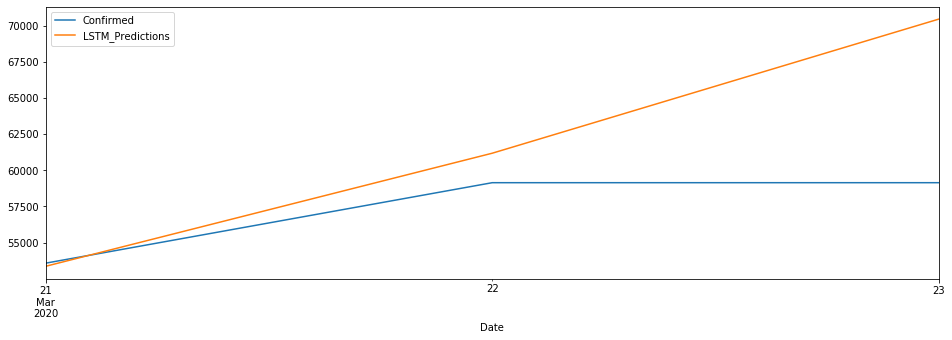

In [48]:
test_data['Confirmed'].plot(figsize = (16,5), legend=True)
test_data['LSTM_Predictions'].plot(legend = True);

In [49]:
lstm_rmse_error_italy = rmse(test_data['Confirmed'], test_data["LSTM_Predictions"])
lstm_mse_error_italy = lstm_rmse_error_italy**2
mean_value = italy['Confirmed'].mean()

print(f'MSE Error: {lstm_mse_error_italy}\nRMSE Error: {lstm_rmse_error_italy}\nMean: {mean_value}')

MSE Error: 43985096.35009314
RMSE Error: 6632.126080684318
Mean: 15559.46875


In [50]:
print(tabulate([
    ['China LSTM Errors', lstm_mse_error_china, lstm_rmse_error_china], 
    ['US LSTM Errors', lstm_mse_error_us, lstm_rmse_error_us],
    ['Italy LSTM Errors', lstm_mse_error_italy, lstm_rmse_error_italy]], 
    
    headers=['Model', 'MSE', "RMSE", "Mean"]))




Model                      MSE      RMSE
-----------------  -----------  --------
China LSTM Errors  6.79481e+06   2606.69
US LSTM Errors     3.26781e+08  18077.1
Italy LSTM Errors  4.39851e+07   6632.13
